In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

%matplotlib inline
df_text = pd.read_csv ("/home/niddal/Desktop/PhD_projects/Twitter_analysis/Datasets/MHC_Datasets/Final_ones/Full_Dataset_Text_desc.csv")
df_text.head(2)

,description,label
0,None,non_spam
1,الحياه بسيطه لماذا نصر على تعقيدها,non_spam


In [2]:
ham_df= df_text[df_text['label'] == 'non_spam']
spam_df= df_text[df_text['label'] == 'spam']

In [3]:
ham_df.shape

(1990, 2)

In [4]:
ham_df= ham_df[pd.notnull(ham_df['description'])]
ham_df.shape

(1988, 2)

In [5]:
spam_df.shape

(519, 2)

In [6]:
spam_df= spam_df[pd.notnull(spam_df['description'])]
spam_df.shape

(519, 2)

In [7]:
df_text_New = df_text[pd.notnull(df_text['description'])]

In [8]:
df_text_New['description'].apply(lambda x: len(x.split(' '))).sum()

19675

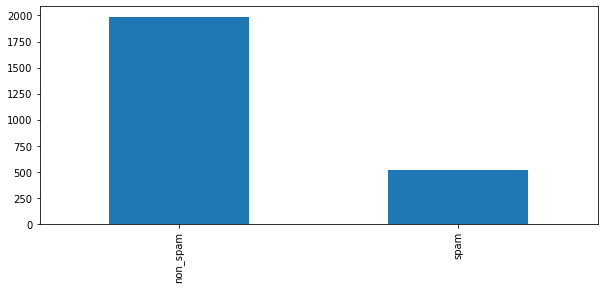

In [9]:
my_tags = ['non_spam','spam']
plt.figure(figsize=(10,4))
df_text_New.label.value_counts().plot(kind='bar');

In [10]:
def print_plot(index):
    example = df_text_New[df_text_New.index == index][['label', 'description']].values[0]
    if len(example) > 0:
        print(example[0])
        print('description:', example[1])

In [11]:
print_plot(9)

non_spam
description: أحب الهلال ولا أحد يعلم مدى حبي له ...❤❤


In [12]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

In [13]:
def clean_tweets(lst):
    # remove twitter Return handles (RT @xxx:)
    lst = np.vectorize(remove_pattern)(lst, "RT @[\w]*:")
    # remove twitter handles (@xxx)
    lst = np.vectorize(remove_pattern)(lst, "@[\w]*")
    # remove URL links (httpxxx)
    lst = np.vectorize(remove_pattern)(lst, "https?://[A-Za-z0-9./]*")
    # remove special characters, numbers, punctuations (except for #)
    lst = np.core.defchararray.replace(lst, "[^a-zA-Z#]", " ")

    return lst

In [14]:
from stop_words import get_stop_words
stop_words = get_stop_words('arabic')

In [15]:
df_text_New['description']= clean_tweets(df_text_New['description'])


<ipython-input-15-73fc120d8790>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text_New['description']= clean_tweets(df_text_New['description'])


In [16]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from stop_words import get_stop_words


tweet_lines = list()
lines = df_text_New['description'].values.tolist()

for line in lines:   
    tokens = word_tokenize(line)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word    
    #table = str.maketrans('', '', string.punctuation)
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words    
    #stop_words = set(stopwords.words('english'))
    stop_words = get_stop_words('arabic')
    words = [w for w in words if not w in stop_words]
    tweet_lines.append(words)

In [17]:
df_text_New['description'].apply(lambda x: len(x.split(' '))).sum()

19675

In [16]:

from matplotlib import pyplot as plt
%matplotlib inline
from gensim.models import KeyedVectors
def load_w2v(filepath,binary):
    return KeyedVectors.load_word2vec_format(filepath, binary=binary)

In [66]:
%%time
from gensim.models import Word2Vec

wv = gensim.models.KeyedVectors.load_word2vec_format("/home/niddal/Desktop/PhD_projects/sentiment-analysis-arabic-master/wiki.ar.vec", binary=True, encoding = 'unicode_escape')
wv.init_sims(replace=True)

CPU times: user 18.1 s, sys: 373 ms, total: 18.4 s
Wall time: 18.4 s


/home/niddal/.local/lib/python3.6/site-packages/gensim/models/keyedvectors.py:2372: RuntimeWarning: overflow encountered in square
  dist = sqrt((m ** 2).sum(-1))[..., newaxis]


# Doc2vec and RF

In [13]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import doc2vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

/home/niddal/anaconda3/envs/py2/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [14]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_text_New.description, df_text_New.label, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [16]:
all_data[:10]

[TaggedDocument(words=['\u200f"أنا', 'أطهر', 'منّهم', 'وأجمل..💎'], tags=['Train_0']),
 TaggedDocument(words=['\u200f\u200f\u200f\u200f\u200e'], tags=['Train_1']),
 TaggedDocument(words=['None'], tags=['Train_2']),
 TaggedDocument(words=['هاشتاقك', 'ترند', 'من', 'الاوائل', 'اتصل', 'او', 'واتساب', '0568858659', 'للدخول', 'مباشرة', 'للمحادثة', 'بالواتس👈🏻', 'https://api.whatsapp.com/send?phone=966568858659'], tags=['Train_3']),
 TaggedDocument(words=['قويه', 'كالحرب', 'ناعمه', 'كالسلام'], tags=['Train_4']),
 TaggedDocument(words=['#صحيفة_المواطن', '..', 'للوطن', 'والمواطن🇸🇦', '📧:almowaten@almowaten.net', '0114615424/104:☎️'], tags=['Train_5']),
 TaggedDocument(words=['None'], tags=['Train_6']),
 TaggedDocument(words=['None'], tags=['Train_7']),
 TaggedDocument(words=['\u200fخذنّي', 'علىْ', 'قول', '[', 'البدو', ']', '[', 'بِ/', 'كِل', 'إللي', 'تبآ', ']', 'إختَرتك', 'إنت', '..', 'وبآقي', 'كِل', 'النآسْ', 'في', 'عيني', '[', 'تهبأ', ']', '~'], tags=['Train_8']),
 TaggedDocument(words=['عملائنا

In [17]:
from gensim.models import Doc2Vec

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 2507/2507 [00:00<00:00, 2729781.96it/s]


In [23]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 2507/2507 [00:00<00:00, 3705116.32it/s]


In [24]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [25]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [26]:
from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

#logreg = LogisticRegression(n_jobs=1, C=1e5)
clf_rf = RandomForestClassifier()
clf_rf.fit(train_vectors_dbow, y_train)

RandomForestClassifier()

In [27]:
logreg = clf_rf.fit(train_vectors_dbow, y_train)
y_pred = clf_rf.predict(test_vectors_dbow)

In [28]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.8950863213811421
              precision    recall  f1-score   support

    non_spam       0.89      1.00      0.94       607
        spam       0.99      0.47      0.63       146

    accuracy                           0.90       753
   macro avg       0.94      0.73      0.79       753
weighted avg       0.91      0.90      0.88       753



In [31]:
#string = 'ضيع وقتك وأنت تبحث عن سالفة الهاشتاق؟! تابع حسابنا وبتلقى السالفة أول بأول. الحساب الاحتياطي للتواصل والإعلان: Salfhtagads@gmail.com'
string = ' ليس الجميع يستحق إحترامك فهناك من يستحق تجاهلك'

lists= string.split(' ')
inferred_vector=model_dbow.infer_vector(doc_words=lists,alpha=0.025,steps=500)
ddf = pd.DataFrame(columns=['tag', 'd2v_Vec'])
ddf.loc[0,'d2v_Vec']=list(inferred_vector)

In [32]:
predict=clf_rf.predict(list(ddf['d2v_Vec']))
print("prediction :", predict)

prediction : ['non_spam']
